<div style='background-image: url(back.jpeg) ; padding: 0px ; background-size:  contain ; border-radius:0px ; height: 250px; background-repeat: no-repeat'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">The  Pseudo-Spectral Method </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Acoustic Waves in 2D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Present a  Fourier Pseudospectral code for solving the 2D acoustic wave equation
* Compute the same using using finite difference scheme 
* Analyze the disperion behaviour in each case 


## Basic Equations
This notebook presents a Fourier Pseudospectral code for solving the 2D acoustic wave equation. Additionally, a solution using finite difference scheme is given for comparison.

The problem of solving the wave equation

\begin{equation}
\partial_t^2 p = c^2 (\partial_{x}^{2}p + \partial_{z}^{2}p) + s
\end{equation}

can be achieved using finite differeces in combination with spectral methods. Here, spatial partial derivatives with respect to $x$ and $z$ are computed via the Fourier method, i.e. 

\begin{equation}
\partial_{x}^{2}p + \partial_{z}^{2}p = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[p]] + \mathscr{F}^{-1}[-k_{z}^{2}\mathscr{F}[p]]
\end{equation}

where $\mathscr{F}$ represents the Fourier transform operator.

As it was the case in previous numerical solutions, we use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the pressure field is extrapolated as

\begin{equation}
\frac{p_{j,k}^{n+1} - 2p_{j,k}^{n} + p_{j,k}^{n-1}}{dt^2}= c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + s_{j,k}^{n}
\end{equation}

In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib.pyplot as plt
from ricker import ricker

# Show the plots in the Notebook
plt.switch_backend("nbagg")

### 1. Fourier derivative method  

In [2]:
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

### 2. Initialization of setup

In [3]:
# Basic parameters
# ---------------------------------------------------------------
nt    = 600     # number of time steps
nx    = 256     # number of grid points in x 
nz    = nx      # number of grid points in z
c     = 343.    # acoustic velocity
eps   = .2      # stability limit
isnap = 600     # snapshot frequency
isx   = int(nx/2)   # source location
isz   = int(nz/2)
f0    = 200.    # Frequency (div by 5)
xmax  = 200
iplot = 20

# initialization of pressure fields
ap = np.zeros((nx, nz), dtype=float)
apnew = np.zeros((nx, nz), dtype=float)
apold = np.zeros((nx, nz), dtype=float)
ad2px = np.zeros((nx, nz), dtype=float)
ad2pz = np.zeros((nx, nz), dtype=float) 
 
sp = np.zeros((nx, nz), dtype= float)
spnew = np.zeros((nx, nz), dtype=float)
spold = np.zeros((nx, nz), dtype=float)
sd2px = np.zeros((nx, nz), dtype=float)
sd2pz = np.zeros((nx, nz), dtype=float); 

sp_sec = -np.abs(sp[1:int(nx/2), 1:int(nz/2)])
ap_sec = -np.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)

dx = xmax/(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx # initialize space coordinates
z  = np.arange(0, nx)*dx # initialize space coordinates
dt = eps*dx/c # calculate tim step from stability criterion

### 3. Source Initialization 

In [4]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# spatial source function
# ---------------------------------------------------------------
sg = np.zeros((nx, nz), dtype= float)
sigma = 1.5*dx
x0 = x[isx-1] 
z0 = z[isz-1] 
for i in range(nx):
    for j in range(nz):
        sg[i,j] = np.exp(-1/sigma**2 * ((x[i]-x0)**2 +(z[j]-z0)**2))
        
sg = sg/np.amax(sg)

### 4. Time Extrapolation
The final solution for our 2D acoustic wave problem after taking into account the finite differences time extrapolation can be written as 

\begin{equation}
p_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + dt^2s_{j,k}^{n} + 2p_{j,k}^{n} - p_{j,k}^{n-1}
\end{equation}

In order to compare the above numerical solution, we implement a 5-point finite difference operator to compute spatial derivatives

\begin{equation}
\partial_t^2 p(x,t) = \frac{-p(x,t+2\mathrm{d}t) + 16p(x,t+\mathrm{d}t) - 30p(x,t) + 16p(x,t-\mathrm{d}t) - p(x,t-2\mathrm{d}t)}{12\mathrm{d}t^2} 
\end{equation}

temporal derivative is done with a 3-point finite difference operator.

#### Numerical dispersion and anysotropy

One of the most significant characteristics of the fourier method is the low numerical dispersion in comparison with the finite difference method. The snapshots displayed below for both solutions allow us to brifly comment two significant observations:

1) There is strong anisotropic dispersion behaviour visible for the finite-difference solution. The most accurate direction occur at $\theta = \pi/4$ 

2) The Fourier solution do not exhibit significant dispersion, but the most importantly, it does not seem to be directionally dependent. In other words the error is isotropic. 

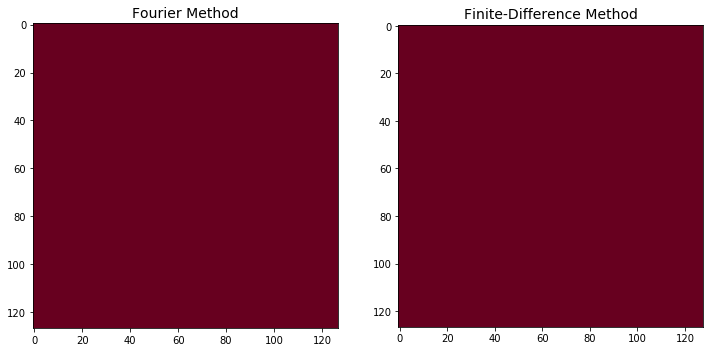

In [5]:
# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# ----------------------------------------------------------------
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
line1 = ax1.imshow(sp_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
line2 = ax2.imshow(ap_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
ax1.set_title('Fourier Method', size=14)
ax2.set_title('Finite-Difference Method', size=14)

plt.ion()   # set interective mode
plt.show()


In [7]:
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    # 2nd space derivative
    for j in np.arange(nz):           
        sd2px[:,j] = fourier_derivative_2nd(sp[:,j].T, dx) 
    for i in np.arange(nx):           
        sd2pz[i,:] = fourier_derivative_2nd(sp[i,:], dx)
        
    # Time Extrapolation
    spnew = 2*sp - spold + c**2 * dt**2 * (sd2px + sd2pz)    
    spnew = spnew + sg*src[it]*dt**2 # Add sources   
    spold, sp = sp, spnew # Time levels
    
    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    for i in range(2, nz-2):
        ad2px[i,:] = (-1./12*ap[i+2,:] + 4./3*ap[i+1,:] - 5./2*ap[i,:] \
                      + 4./3*ap[i-1,:] - 1./12*ap[i-2,:])/dx**2 # Space derivative 
    for i in range(2, nx-2):
        ad2pz[:,i] = (-1./12*ap[:,i+2] + 4./3*ap[:,i+1] - 5./2*ap[:,i] \
                      + 4./3*ap[:,i-1] - 1./12*ap[:,i-2])/dx**2 # Space derivative 
        
    apnew = 2*ap - apold + dt**2 * c**2 * (ad2px + ad2pz) # Time Extrapolation    
    apnew = apnew + sg*src[it]*dt**2 # Add source    
    apold, ap = ap, apnew # Time levels
    
    # Select Sections for plotting
    sp_sec = -np.abs(sp[1:int(nx/2), 1:int(nz/2)])
    ap_sec = -np.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)
    
    # To avoid testing (with py.test nbval ...) the plotting section 
    # NBVAL_IGNORE_OUTPUT
    # --------------------------------------  
    # Animation plot. Display solution  
    # --------------------------------------
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        line1 = ax1.imshow(sp_sec, interpolation="bicubic", cmap=plt.cm.RdBu) 
        line2 = ax2.imshow(ap_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()
     

<Figure size 432x288 with 0 Axes>